In [ ]:
import os
import pandas as pd
import numpy as np
import torch as tc
import torch.nn as nn
from tqdm import tqdm
import time
import json
import itertools
import matplotlib.pyplot as plt

# --- Importe suas classes ---
# (Assumindo que estão no PYTHONPATH ou na mesma pasta)
from equation.option_pricing import BlackScholes
from optimize.option_princing import BlackScholeOptimizer
from method.nn import MLP, ResNet
from method.hnn import HybridCQN 
from method.qnn import QuantumNeuralNetwork
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch as tc
import torch.nn as nn
import numpy as np
import json

# --- Importe suas classes ---
# (Precisamos delas para RECONSTRUIR a arquitetura antes de carregar os pesos)
from equation.option_pricing import BlackScholes
from method.nn import MLP, ResNet
from method.hnn import HybridCQN
from method.qnn import QuantumNeuralNetwork



2025-10-20 14:40:18.256663: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-20 14:40:18.287634: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-20 14:40:18.945896: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Carregando sumários de resultados...
Carregado 90 runs de 'experimentos_pinn/sumario_classico.csv'
AVISO: 'experimentos_pinn/sumario_hibrido.csv' não encontrado. Pulando.

--- Sumário dos Experimentos (Amostra) ---
  model_type run_id_prefix     lr  epochs activation  hidden  blocks  seed  \
0     ResNet        ResNet  0.002    5000     Tanh()       2       1  1900   
1     ResNet        ResNet  0.002    5000     Tanh()       2       1  1905   
2     ResNet        ResNet  0.002    5000     Tanh()       2       1  1924   
3     ResNet        ResNet  0.002    5000     Tanh()       2       1  1925   
4     ResNet        ResNet  0.002    5000     Tanh()       2       1  1926   

                     run_id  mse_teste_normalizado  mse_teste_desnormalizado  \
0  ResNet_n_2_b_1_seed_1900               0.000605                 11.857712   
1  ResNet_n_2_b_1_seed_1905               0.000261                  5.125250   
2  ResNet_n_2_b_1_seed_1924               0.000457                  8.951900

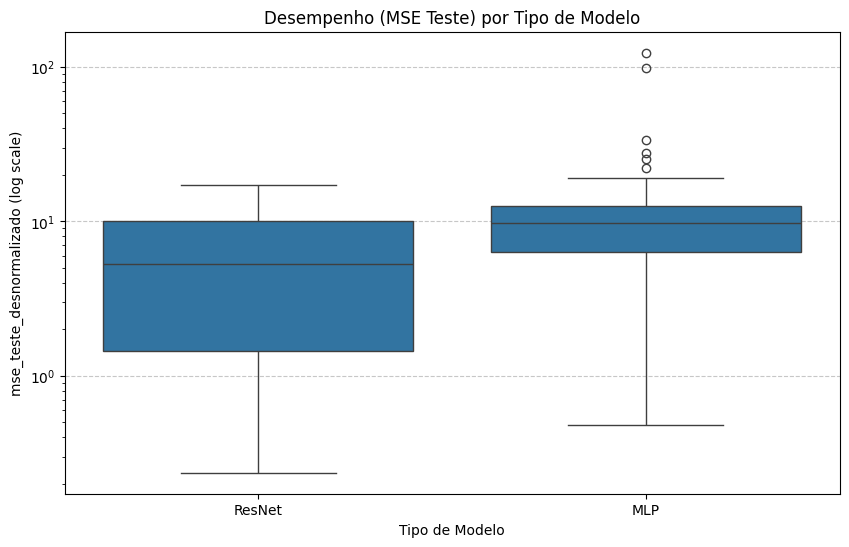

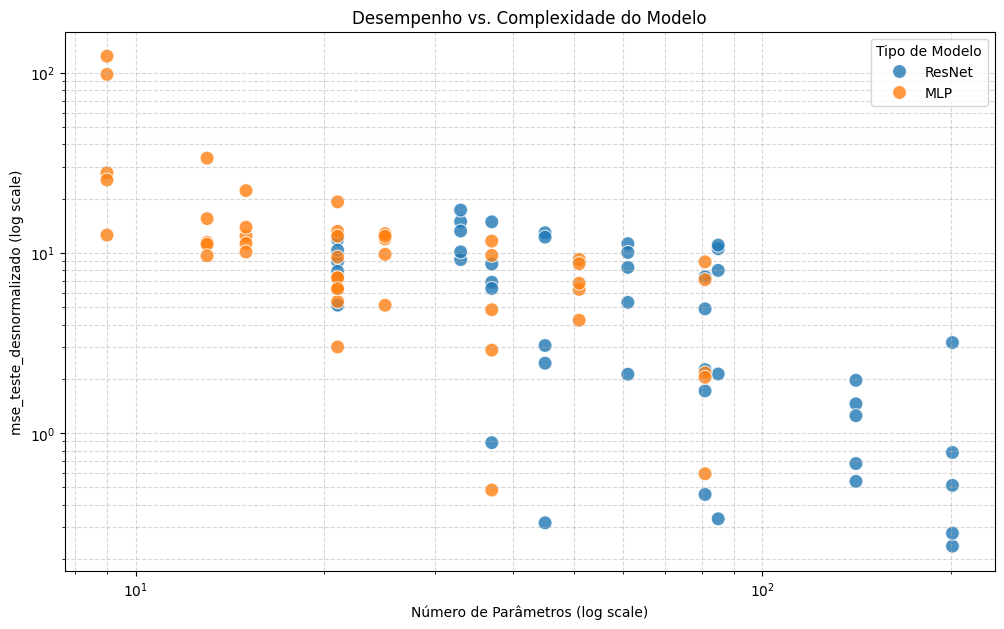

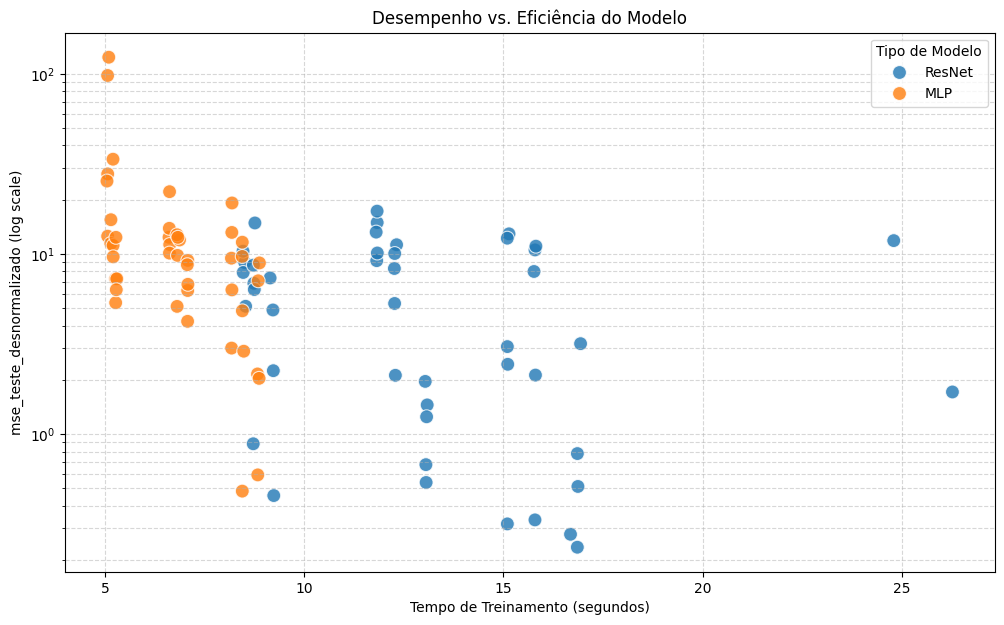

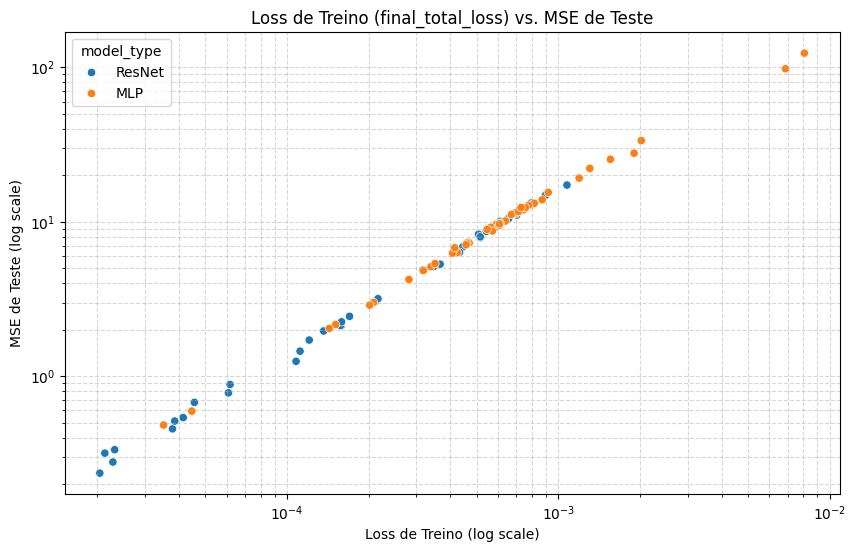

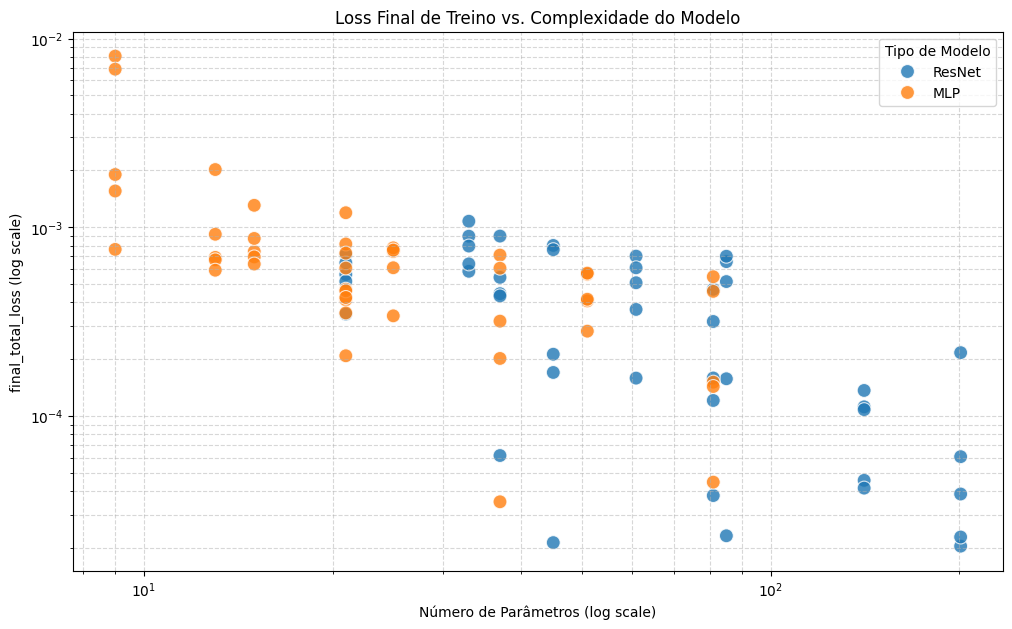

Gerando plots de impacto da arquitetura...


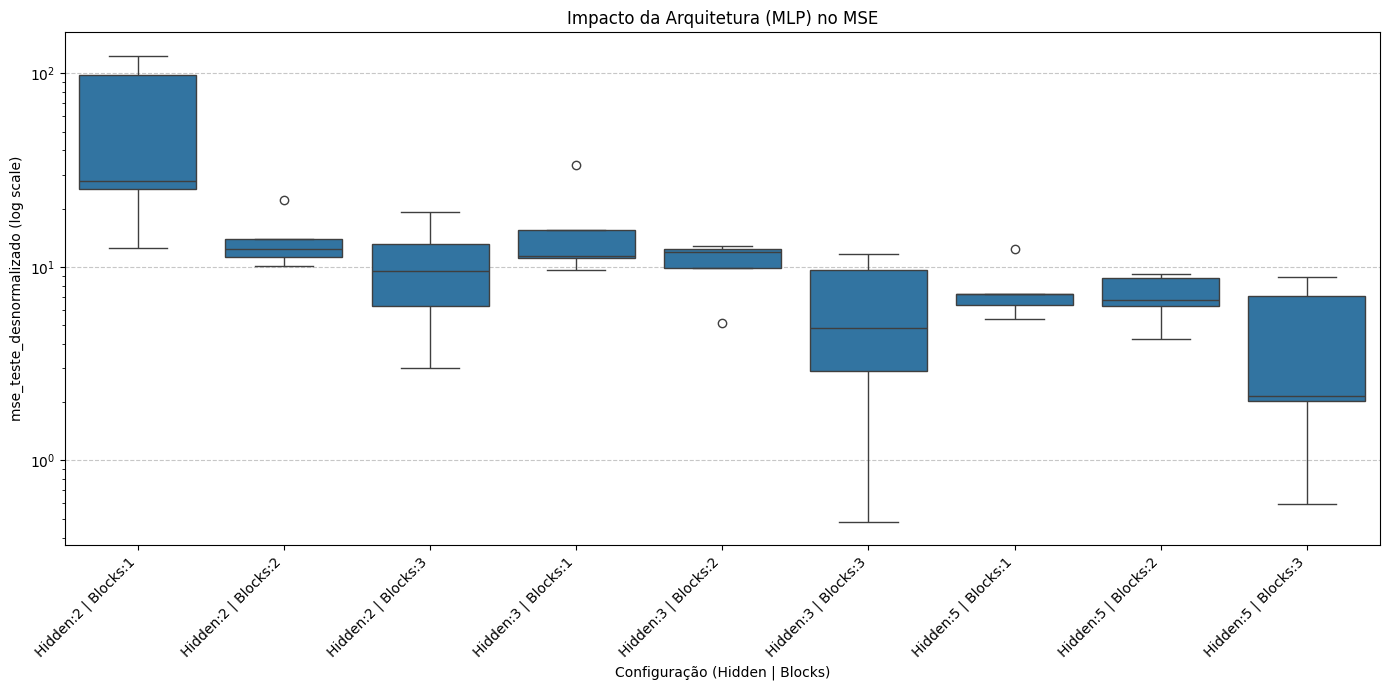

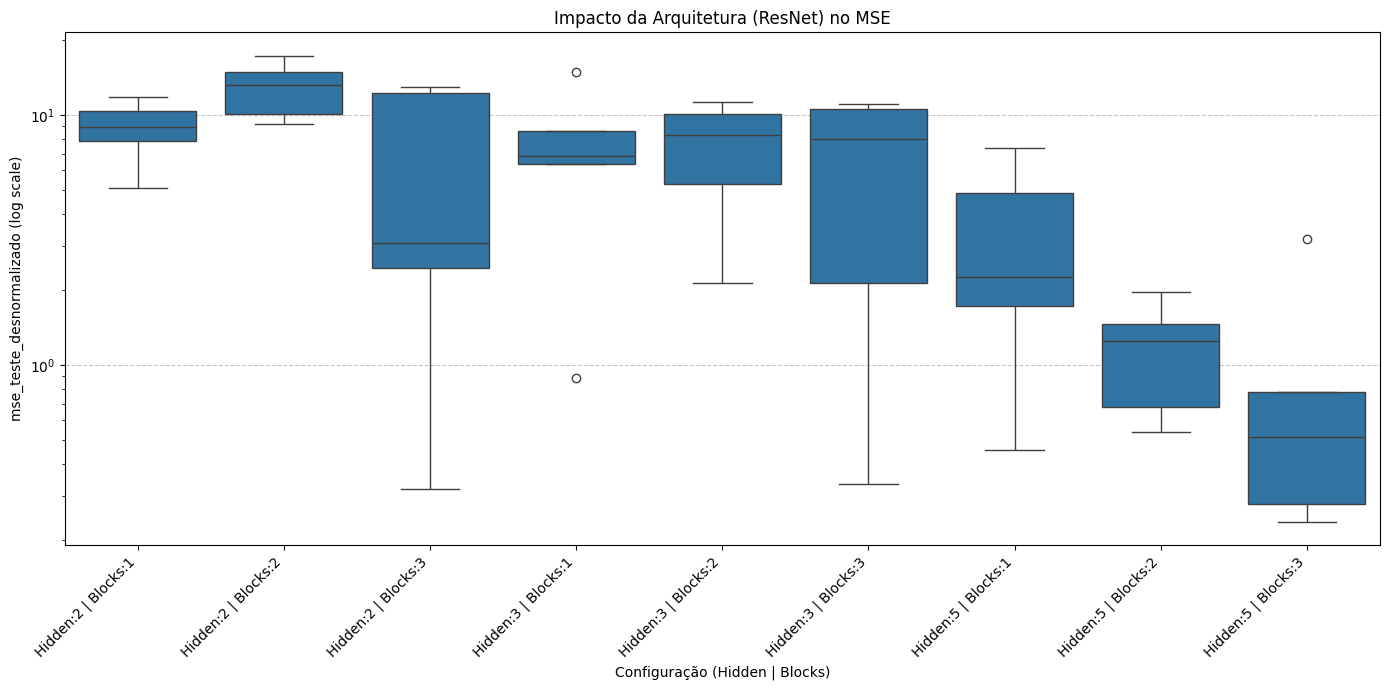

Gerando plot de histórico de loss dos melhores modelos...


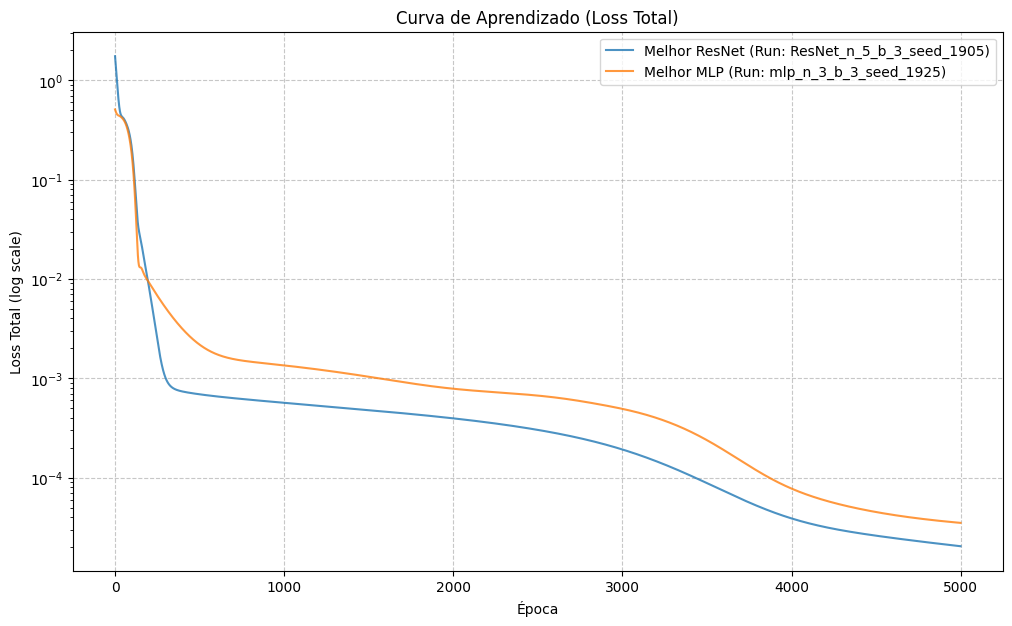

Gerando plot de loss média com incerteza (por seed)...


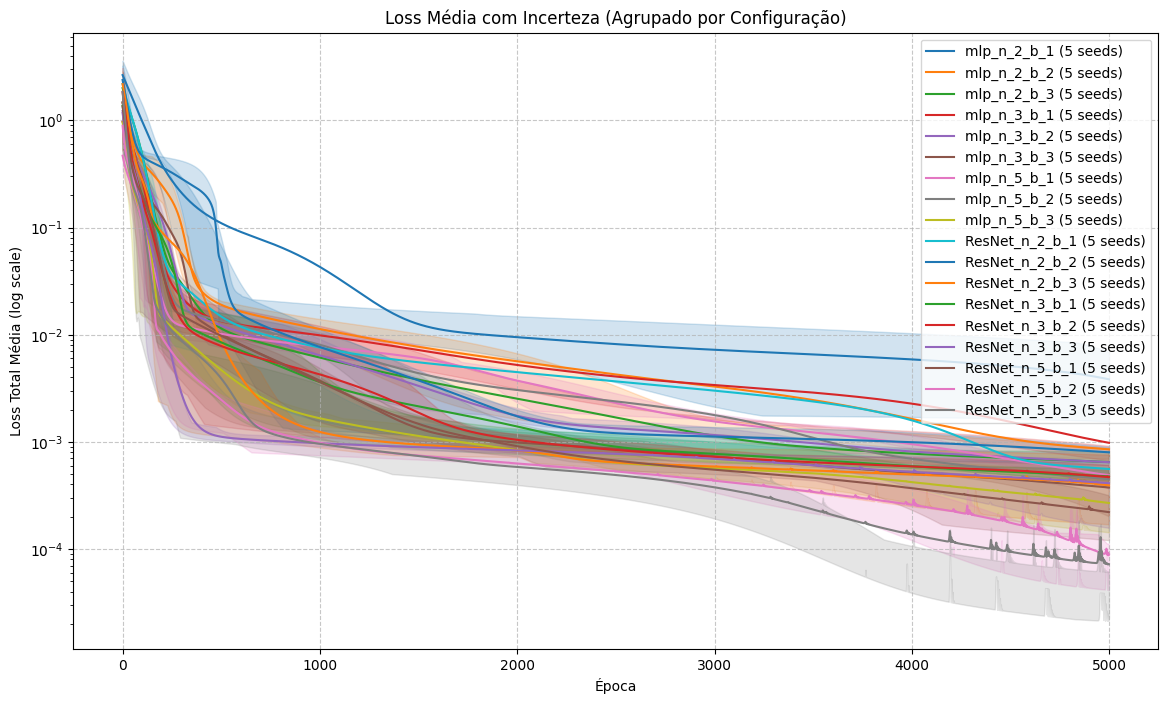

Carregando o MELHOR modelo geral para plot 3D...

Melhor Modelo Encontrado:
  Run ID: ResNet_n_5_b_3_seed_1905
  Tipo:   ResNet
  MSE:    0.235861
  Path:   experimentos_pinn/modelos_salvos/modelo_ResNet_n_5_b_3_seed_1905.pth
Arquitetura recriada e pesos carregados com sucesso.
Gerando plots 3D da solução (Verdadeiro vs. Predito)...


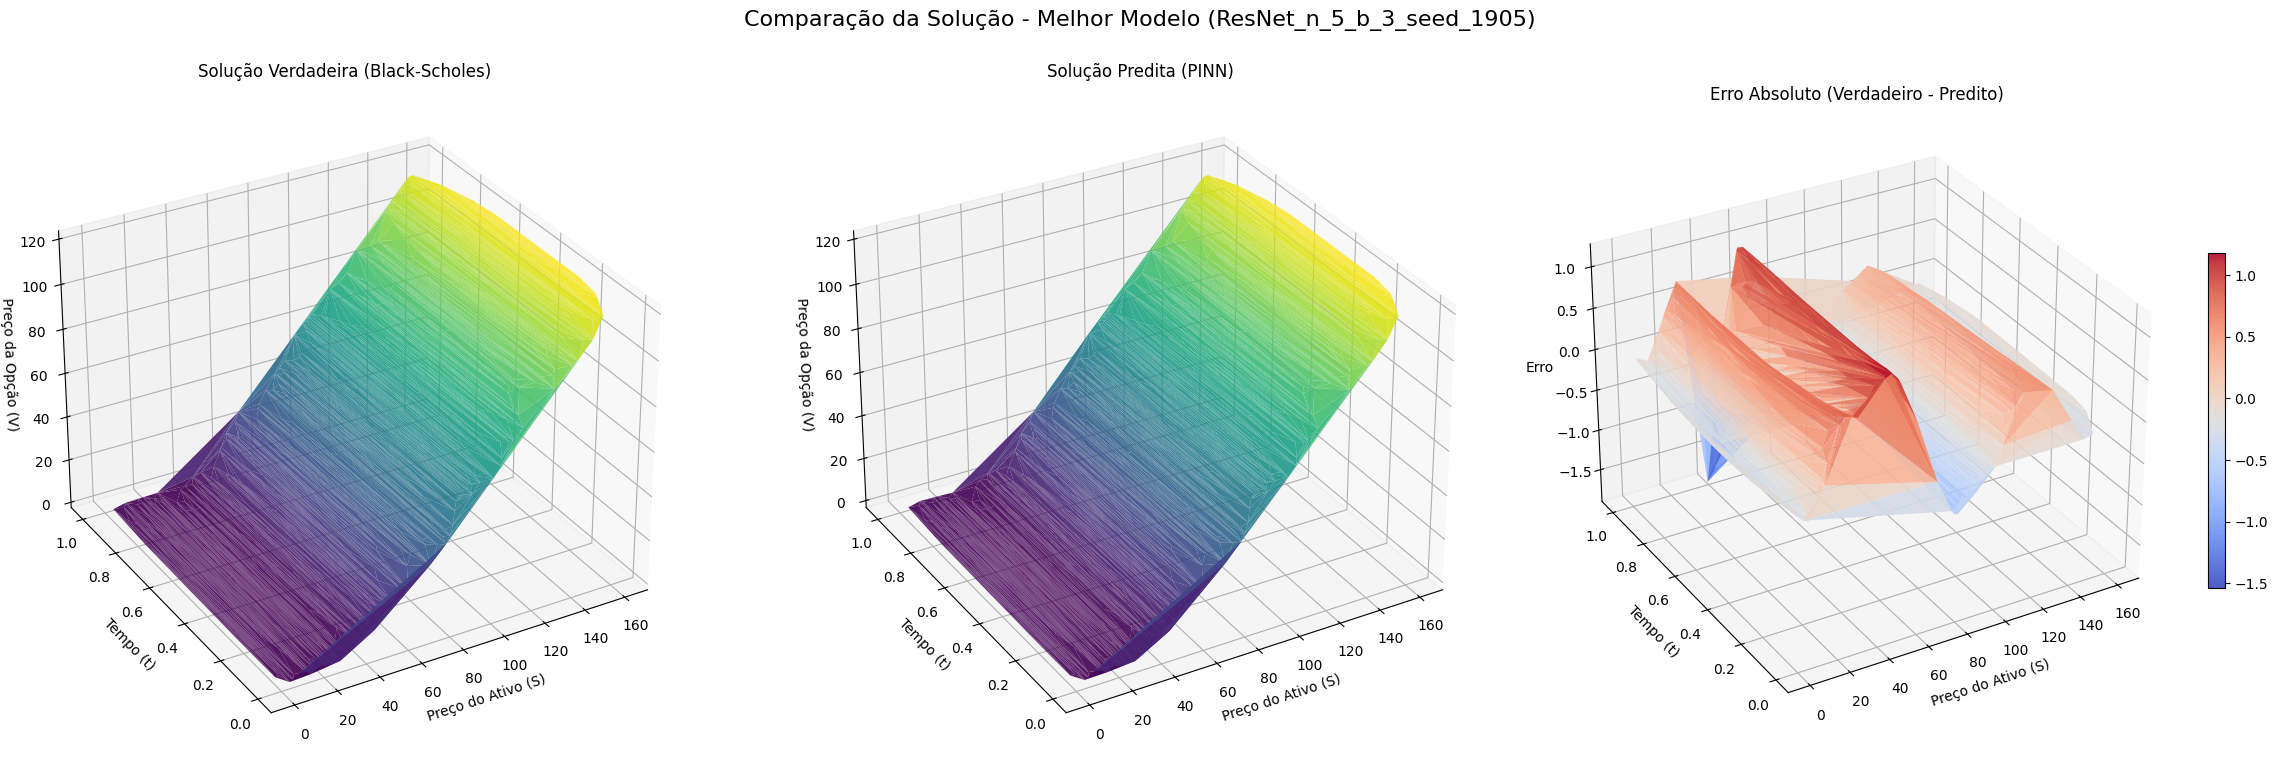


Análise concluída.


In [ ]:

# =============================================================================
# 0. CONFIGURAÇÃO
# =============================================================================

# Diretório onde os resultados foram salvos
RESULTS_DIR = "experimentos_pinn"
SUMMARY_CLASSIC_PATH = os.path.join(RESULTS_DIR, "sumario_classico.csv")
SUMMARY_HYBRID_PATH = os.path.join(RESULTS_DIR, "sumario_hibrido.csv")

# Métrica principal para avaliar os modelos (use a desnormalizada)
MSE_COLUMN = 'mse_teste_desnormalizado'
LOSS_COLUMN = 'final_total_loss' # ou 'mean_last_100_loss'

# Mapeamento de string de ativação para objeto (necessário para recarregar)
activation_map = {
    "Tanh()": nn.Tanh(),
    "ReLU()": nn.ReLU(),
    # Adicione outras ativações se você as usou
}

# Constantes de normalização (as mesmas usadas no treino)
S_max = 160.0
T = 1.0
V_max = 140.0

def load_loss_history(path):
    """Função auxiliar para carregar um histórico de loss de um JSON."""
    try:
        with open(path, 'r') as f:
            history = json.load(f)
        return history
    except Exception as e:
        print(f"AVISO: Não foi possível carregar o histórico de loss: {e}")
        return None

# =============================================================================
# 1. CARREGAR OS DADOS DO SUMÁRIO
# =============================================================================

print("Carregando sumários de resultados...")
all_dfs = []

try:
    df_classic = pd.read_csv(SUMMARY_CLASSIC_PATH)
    all_dfs.append(df_classic)
    print(f"Carregado {len(df_classic)} runs de '{SUMMARY_CLASSIC_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_CLASSIC_PATH}' não encontrado. Pulando.")

try:
    df_hybrid = pd.read_csv(SUMMARY_HYBRID_PATH)
    all_dfs.append(df_hybrid)
    print(f"Carregado {len(df_hybrid)} runs de '{SUMMARY_HYBRID_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_HYBRID_PATH}' não encontrado. Pulando.")

if not all_dfs:
    print("ERRO: Nenhum arquivo de sumário encontrado. Rode 'run_experiments.py' primeiro.")
    exit()

# Concatena todos os dataframes para análise comparativa
df_all = pd.concat(all_dfs, ignore_index=True)

print("\n--- Sumário dos Experimentos (Amostra) ---")
print(df_all.head())
print("\n")


# =============================================================================
# 2. PLOTS ESTATÍSTICOS (Análise Comparativa)
# =============================================================================

print("Gerando plots estatísticos...")

# --- Plot 2.1: Desempenho (MSE) por Tipo de Modelo ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x='model_type', y=MSE_COLUMN)
plt.title('Desempenho (MSE Teste) por Tipo de Modelo')
plt.ylabel(f'{MSE_COLUMN} (log scale)')
plt.xlabel('Tipo de Modelo')
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Plot 2.2: Desempenho (MSE) vs. Complexidade (Parâmetros) ---
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_all, x='num_params', y=MSE_COLUMN, hue='model_type', s=100, alpha=0.8)
plt.title('Desempenho vs. Complexidade do Modelo')
plt.ylabel(f'{MSE_COLUMN} (log scale)')
plt.xlabel('Número de Parâmetros (log scale)')
plt.yscale('log')
plt.xscale('log')
plt.legend(title='Tipo de Modelo')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- Plot 2.3: Desempenho (MSE) vs. Eficiência (Tempo) ---
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_all, x='training_time_sec', y=MSE_COLUMN, hue='model_type', s=100, alpha=0.8)
plt.title('Desempenho vs. Eficiência do Modelo')
plt.ylabel(f'{MSE_COLUMN} (log scale)')
plt.xlabel('Tempo de Treinamento (segundos)')
plt.yscale('log')
plt.legend(title='Tipo de Modelo')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- Plot 2.4: Loss de Treino vs. MSE de Teste ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_all, x=LOSS_COLUMN, y=MSE_COLUMN, hue='model_type')
plt.title(f'Loss de Treino ({LOSS_COLUMN}) vs. MSE de Teste')
plt.xlabel(f'Loss de Treino (log scale)')
plt.ylabel(f'MSE de Teste (log scale)')
plt.yscale('log')
plt.xscale('log')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- Plot 2.5: Loss de Treino vs. Número de Parâmetros ---
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_all, x='num_params', y=LOSS_COLUMN, hue='model_type', s=100, alpha=0.8)
plt.title(f'Loss Final de Treino vs. Complexidade do Modelo')
plt.ylabel(f'{LOSS_COLUMN} (log scale)')
plt.xlabel('Número de Parâmetros (log scale)')
plt.yscale('log')
plt.xscale('log')
plt.legend(title='Tipo de Modelo')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- Plot 2.6: Análise de Impacto da Arquitetura por Modelo ---
print("Gerando plots de impacto da arquitetura...")

# Mapeia os parâmetros de arquitetura para cada tipo de modelo
arch_params_map = {
    'MLP':    {'params': ['hidden', 'blocks'], 'labels': ['Hidden', 'Blocks']},
    'ResNet': {'params': ['hidden', 'blocks'], 'labels': ['Hidden', 'Blocks']},
    'QPINN':  {'params': ['n_qubits', 'n_layers'], 'labels': ['Qubits', 'Layers']}
}

for model_type, arch_info in arch_params_map.items():
    df_subset = df_all[df_all['model_type'] == model_type].copy()
    
    # Pula se não houver dados para este tipo de modelo
    if df_subset.empty:
        continue
        
    p1, p2 = arch_info['params']
    l1, l2 = arch_info['labels']
    
    # Pula se as colunas de arquitetura não estiverem no dataframe
    if p1 not in df_subset.columns or p2 not in df_subset.columns:
        print(f"AVISO: Pulando plot de arquitetura para '{model_type}' pois faltam as colunas '{p1}' ou '{p2}'.")
        continue

    # Cria uma coluna de "configuração" para o eixo X
    df_subset['config'] = f'{l1}:' + df_subset[p1].astype(str) + f' | {l2}:' + df_subset[p2].astype(str)
    
    # Ordena para o gráfico ficar bonito
    df_subset = df_subset.sort_values(by=[p1, p2])
    
    plt.figure(figsize=(14, 7))
    sns.boxplot(data=df_subset, x='config', y=MSE_COLUMN)
    plt.title(f'Impacto da Arquitetura ({model_type}) no MSE')
    plt.ylabel(f'{MSE_COLUMN} (log scale)')
    plt.xlabel(f'Configuração ({l1} | {l2})')
    plt.yscale('log')
    plt.xticks(rotation=45, ha="right") # Rotaciona e alinha os labels
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() # Ajusta o layout para evitar sobreposição de labels
    plt.show()


# =============================================================================
# 3. PLOTS DE HISTÓRICO DE LOSS
# =============================================================================

# --- Plot 3.1: Curvas de Aprendizado (Melhores Modelos) ---
print("Gerando plot de histórico de loss dos melhores modelos...")
plt.figure(figsize=(12, 7))
plt.title('Curva de Aprendizado (Loss Total)')

# Encontra o melhor de cada tipo
model_types = df_all['model_type'].unique()
for m_type in model_types:
    df_subset = df_all[df_all['model_type'] == m_type]
    if df_subset.empty:
        continue
    
    best_run = df_subset.loc[df_subset[MSE_COLUMN].idxmin()]
    history = load_loss_history(best_run['loss_history_path'])
    
    if history and 'Total' in history:
        loss_total = history['Total']
        plt.plot(loss_total, label=f"Melhor {m_type} (Run: {best_run['run_id']})", alpha=0.8)

plt.xlabel('Época')
plt.ylabel('Loss Total (log scale)')
plt.yscale('log')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.show()


# --- Plot 3.2: Curva de Aprendizado Média com Incerteza (por Seed) ---
print("Gerando plot de loss média com incerteza (por seed)...")
plt.figure(figsize=(14, 8))
plt.title('Loss Média com Incerteza (Agrupado por Configuração)')

config_cols_map = {
    'MLP': ['model_type', 'lr', 'epochs', 'activation', 'hidden', 'blocks'],
    'ResNet': ['model_type', 'lr', 'epochs', 'activation', 'hidden', 'blocks'],
    'QPINN': ['model_type', 'lr', 'epochs', 'n_qubits', 'n_layers']
}

# Itera sobre cada tipo de modelo presente no dataframe
for model_type, config_cols in config_cols_map.items():
    df_subset = df_all[df_all['model_type'] == model_type].copy()
    if df_subset.empty:
        continue

    # Verifica se todas as colunas de config existem para este subset
    if not all(col in df_subset.columns for col in config_cols):
        print(f"AVISO: Pulando análise de incerteza para '{model_type}' pois faltam colunas de configuração.")
        continue
    
    # Agrupa por configurações idênticas (ignorando a seed)
    grouped = df_subset.groupby(config_cols)
    
    for name, group in grouped:
        # Apenas plota se houver mais de uma seed para estatística
        if len(group) > 1:
            all_losses = []
            for idx, row in group.iterrows():
                history = load_loss_history(row['loss_history_path'])
                if history and 'Total' in history:
                    all_losses.append(history['Total'])
            
            if len(all_losses) < 2:
                continue
                
            # Garante que todos os históricos tenham o mesmo tamanho (trunca pelo menor)
            min_len = min(len(h) for h in all_losses)
            loss_array = np.array([h[:min_len] for h in all_losses])
            
            # Calcula a média e os percentis 25 e 75 ao longo das seeds (axis=0)
            mean_loss = np.mean(loss_array, axis=0)
            p25_loss = np.percentile(loss_array, 25, axis=0)
            p75_loss = np.percentile(loss_array, 75, axis=0)
            
            config_label = group.iloc[0]['run_id'].replace(f"_seed_{group.iloc[0]['seed']}", "")
            
            line, = plt.plot(mean_loss, label=f"{config_label} ({len(group)} seeds)")
            plt.fill_between(range(len(mean_loss)), p25_loss, p75_loss, color=line.get_color(), alpha=0.2)

plt.xlabel('Época')
plt.ylabel('Loss Total Média (log scale)')
plt.yscale('log')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.show()


# =============================================================================
# 4. PLOT DA SOLUÇÃO 3D (Melhor Modelo Geral)
# =============================================================================

print("Carregando o MELHOR modelo geral para plot 3D...")

# --- A. Encontrar o melhor modelo ---
best_run_config = df_all.loc[df_all[MSE_COLUMN].idxmin()]

print(f"\nMelhor Modelo Encontrado:")
print(f"  Run ID: {best_run_config['run_id']}")
print(f"  Tipo:   {best_run_config['model_type']}")
print(f"  MSE:    {best_run_config[MSE_COLUMN]:.6f}")
print(f"  Path:   {best_run_config['model_path']}")

# --- B. Recriar a arquitetura do modelo ---
model_type = best_run_config['model_type']
model = None

try:
    activation_str = best_run_config.get('activation', 'Tanh()')
    activation = activation_map[activation_str]

    if model_type == "MLP":
        model = MLP(hidden=int(best_run_config['hidden']), blocks=int(best_run_config['blocks']), 
                    activation=activation)
    
    elif model_type == "ResNet":
        model = ResNet(hidden=int(best_run_config['hidden']), blocks=int(best_run_config['blocks']), 
                       activation=activation)
    
    elif model_type == "QPINN":
        qnn = QuantumNeuralNetwork(n_qubits=int(best_run_config['n_qubits']), 
                                   n_layers=int(best_run_config['n_layers']))
        model = HybridCQN(classical_pre=None, qnn_block=qnn, classical_post=None)
    
    if model is None:
        raise ValueError(f"Tipo de modelo '{model_type}' não tratado no script de plot.")

    # --- C. Carregar os pesos salvos ---
    model.load_state_dict(tc.load(best_run_config['model_path']))
    model.eval() 
    print("Arquitetura recriada e pesos carregados com sucesso.")

except Exception as e:
    print(f"ERRO AO CARREGAR O MODELO: {e}")
    print("Pulando plot 3D. Verifique se as classes do modelo estão importadas.")
    exit()


# --- D. Gerar dados de teste (com a mesma seed do treino) ---
bse = BlackScholes(eps=1e-10)
data_teste = bse.generate_data(seed=42)

S_test, t_test, V_true = data_teste['domain']
S_test_flat, t_test_flat, V_true_flat = S_test.ravel(), t_test.ravel(), V_true.ravel()

# --- E. Fazer a predição com o modelo carregado ---
_S_test_norm = tc.tensor(S_test / S_max).float()
_t_test_norm = tc.tensor(t_test / T).float()

with tc.no_grad():
    V_pred_norm = model(tc.cat([_S_test_norm, _t_test_norm], dim=1))

V_pred = V_pred_norm.numpy() * V_max
V_pred_flat = V_pred.ravel()

# --- F. Plotar os gráficos 3D ---
print("Gerando plots 3D da solução (Verdadeiro vs. Predito)...")

fig = plt.figure(figsize=(24, 8))
fig.suptitle(f"Comparação da Solução - Melhor Modelo ({best_run_config['run_id']})", fontsize=16)

# Plot 1: Solução Verdadeira
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.set_title('Solução Verdadeira (Black-Scholes)')
ax1.plot_trisurf(S_test_flat, t_test_flat, V_true_flat, cmap='viridis', edgecolor='none', alpha=0.9)
ax1.set_xlabel('Preço do Ativo (S)')
ax1.set_ylabel('Tempo (t)')
ax1.set_zlabel('Preço da Opção (V)')
ax1.view_init(30, -120)

# Plot 2: Solução Predita (PINN)
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.set_title('Solução Predita (PINN)')
ax2.plot_trisurf(S_test_flat, t_test_flat, V_pred_flat, cmap='viridis', edgecolor='none', alpha=0.9)
ax2.set_xlabel('Preço do Ativo (S)')
ax2.set_ylabel('Tempo (t)')
ax2.set_zlabel('Preço da Opção (V)')
ax2.view_init(30, -120)

# Plot 3: Erro (Verdadeiro - Predito)
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
erro = V_true_flat - V_pred_flat
ax3.set_title('Erro Absoluto (Verdadeiro - Predito)')
sc = ax3.plot_trisurf(S_test_flat, t_test_flat, erro, cmap='coolwarm', edgecolor='none', alpha=0.9)
fig.colorbar(sc, ax=ax3, shrink=0.5)
ax3.set_xlabel('Preço do Ativo (S)')
ax3.set_ylabel('Tempo (t)')
ax3.set_zlabel('Erro')
ax3.view_init(30, -120)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nAnálise concluída.")

